## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

## Exploring the data

In [2]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('aclImdb/train')
test_ds = text_dataset_from_directory('aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.
Found 25000 files belonging to 2 classes.


<ipython-input-2-0ca1fd28bb81>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xts['text'] = xts['text'].map(lambda x: x.decode())


In [3]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
70759,"This is the best Emma in existence in my opinion. Having seen the other version (1996) which is also good, and read the book, I think I can safely say with confidence that this is the true interpr...",1
13322,"Three girls, the youngest descendents of the Gaylord family, one of America's most royal families, are orphaned at a young age. Right before he goes off to France to fight in WWI, their father tel...",1
40758,"The movie was watchable while Nicolson was on the screen. However, I had to fight against passing out from boredom when the film depended on Meryl Streep to carry scenes without Jack; she was as b...",0
3125,"This movie deserves a better review than the previous one by Melendez from Brazil. It is true that the plot is complex and not easy to follow, but if you are looking for easy entertainment, this i...",2
8274,"Alex Kingston IS Moll Flanders. Please, forget the cotton-candy version that has Morgan Freeman in the cast (though, I _adore_ Stockard Channing). This is the real thing! We get to see the real, h...",2


In [4]:
print(dfTrain.loc[0, 'text'])

Saw the episode tonight on TV, and really enjoyed it. Its just a great series isn't it, and it was really bugging me what the music/song was and wasted an hour or so on the net looking for the name of the music and ended up here! So thanks for the information on the song at the end of the episode. I knew I had heard the tune before, (but not the lyrics) but just couldn't place it! Somehow it seems more appropriate how its used here with Seymour waiting for Fry to come back for the rest of his life<br /><br />"If it takes forever, I will wait for you, for a thousand summers, I will wait for you" <br /><br />compared with the closing scene at the service station in 'The Umbrellas Of Cherbourg' where both of them meet again by accident and each find out that the other is married and has children. Maybe that's why there are no lyrics to the song in this scene as they only sort of 1/2 waited. Still, its a memorable scene as I haven't seen this film in almost 15 years and but I remember it a

## Tokenize the text

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [6]:
print(train_sequences[0])

[216, 1, 423, 3992, 20, 247, 2, 64, 511, 9, 92, 40, 3, 80, 202, 215, 9, 2, 9, 13, 64, 21252, 70, 48, 1, 227, 652, 13, 2, 1033, 32, 548, 39, 36, 20, 1, 5708, 262, 16, 1, 394, 4, 1, 227, 2, 1041, 53, 133, 36, 1166, 16, 1, 1591, 20, 1, 652, 30, 1, 127, 4, 1, 423, 10, 694, 10, 67, 557, 1, 3136, 164, 18, 21, 1, 4388, 18, 40, 421, 266, 9, 811, 9, 184, 50, 2280, 88, 92, 327, 133, 15, 6591, 1067, 16, 8240, 5, 214, 140, 16, 1, 372, 4, 24, 115, 7, 7, 45, 9, 296, 1485, 10, 82, 881, 16, 22, 16, 3, 3206, 16872, 10, 82, 881, 16, 22, 7, 7, 1106, 15, 1, 2731, 129, 30, 1, 2411, 1596, 8, 1079, 27450, 4, 87409, 113, 193, 4, 90, 911, 173, 31, 1650, 2, 253, 167, 42, 12, 1, 84, 6, 991, 2, 44, 478, 273, 196, 134, 47, 23, 54, 4388, 5, 1, 652, 8, 11, 129, 14, 33, 62, 435, 4, 310, 228, 4560, 132, 92, 3, 914, 129, 14, 10, 754, 110, 11, 19, 8, 221, 1133, 151, 2, 18, 10, 398, 9, 2, 1, 3136]


In [7]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['saw', 'the', 'episode', 'tonight', 'on', 'tv', 'and', 'really', 'enjoyed', 'it', 'its', 'just', 'a', 'great', 'series', "isn't", 'it', 'and', 'it', 'was', 'really', 'bugging', 'me', 'what', 'the', 'music', 'song', 'was', 'and', 'wasted', 'an', 'hour', 'or', 'so', 'on', 'the', 'net', 'looking', 'for', 'the', 'name', 'of', 'the', 'music', 'and', 'ended', 'up', 'here', 'so', 'thanks', 'for', 'the', 'information', 'on', 'the', 'song', 'at', 'the', 'end', 'of', 'the', 'episode', 'i', 'knew', 'i', 'had', 'heard', 'the', 'tune', 'before', 'but', 'not', 'the', 'lyrics', 'but', 'just', "couldn't", 'place', 'it', 'somehow', 'it', 'seems', 'more', 'appropriate', 'how', 'its', 'used', 'here', 'with', 'seymour', 'waiting', 'for', 'fry', 'to', 'come', 'back', 'for', 'the', 'rest', 'of', 'his', 'life', 'br', 'br', 'if', 'it', 'takes', 'forever', 'i', 'will', 'wait', 'for', 'you', 'for', 'a', 'thousand', 'summers', 'i', 'will', 'wait', 'for', 'you', 'br', 'br', 'compared', 'with', 'the', 'closing', 

In [8]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [9]:
MAX_SEQUENCE_LENGTH

2493

In [10]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [12]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [13]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=128, epochs=5
)

Epoch 1/5
586/586 [==============================] - 37s 63ms/step - loss: -1052158.6250 - accuracy: 0.1667 - val_loss: 1291083.5000 - val_accuracy: 0.5000
Epoch 2/5
586/586 [==============================] - 37s 63ms/step - loss: -1591447.6250 - accuracy: 0.1667 - val_loss: 1892638.2500 - val_accuracy: 0.5000
Epoch 3/5
586/586 [==============================] - 37s 64ms/step - loss: -2265468.2500 - accuracy: 0.1667 - val_loss: 2631104.0000 - val_accuracy: 0.5000
Epoch 4/5
586/586 [==============================] - 35s 59ms/step - loss: -3079571.2500 - accuracy: 0.1667 - val_loss: 3511104.7500 - val_accuracy: 0.5000
Epoch 5/5
586/586 [==============================] - 36s 62ms/step - loss: -4040762.2500 - accuracy: 0.1667 - val_loss: 4541578.0000 - val_accuracy: 0.5000


# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [18]:
glove_wiki = KeyedVectors.load_word2vec_format('glove.6B.300d.txt', binary=False, no_header=True)

In [22]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [23]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=128, epochs=5
)

Epoch 1/5
586/586 [==============================] - 84s 142ms/step - loss: -950.6772 - accuracy: 0.1666 - val_loss: 3875.9309 - val_accuracy: 0.5000
Epoch 2/5
586/586 [==============================] - 80s 136ms/step - loss: -14368.1436 - accuracy: 0.1667 - val_loss: 29481.4609 - val_accuracy: 0.5000
Epoch 3/5
586/586 [==============================] - 88s 151ms/step - loss: -57332.1562 - accuracy: 0.1667 - val_loss: 90211.8594 - val_accuracy: 0.5000
Epoch 4/5
586/586 [==============================] - 87s 149ms/step - loss: -140412.2188 - accuracy: 0.1667 - val_loss: 194333.0469 - val_accuracy: 0.5000
Epoch 5/5
586/586 [==============================] - 87s 149ms/step - loss: -269896.3750 - accuracy: 0.1667 - val_loss: 345896.6250 - val_accuracy: 0.5000


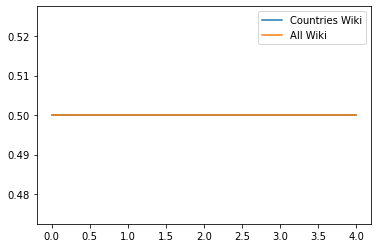

In [24]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()